# Course Project – Data Mining 2025
## Data-Taxi trip

## Introduction
This project was conducted as part of a machine learning study focusing on supervised and unsupervised learning methods.  
The dataset used in this project refers to a pilot conducted in San Francisco that collected taxi trip data from 2023.
The analysis was designed to explore patterns, predict outcomes, and optimize drivers’ decision-making processes on whether to take a trip or not.

The dataset was taken from data.gov.
Link to the dataset: https://catalog.data.gov/dataset/taxi-trips-8c270 and it has 4M rows with 28 columns

The work is divided into two main parts:  
1. **Unsupervised learning:** Applying clustering and pattern recognition techniques to uncover hidden structures in the data and learn what makes a trip profitable for a taxi driver.  
2. **Supervised learning:** Applying and optimizing models to predict whether a trip will be profitable or not.

The project was a collaborative effort, combining data preprocessing, supervised learning implementation, and unsupervised analysis to extract meaningful insights from the dataset.

 **Team members: Esty Carmiel and Dean Israel**

#### Relevants  librarries

In [4]:
# ! pip install folium
# ! pip install lightgbm
# ! pip install xgboost
# ! pip install geopandas shapely
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score ,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# libreries for k- means & DBSCAN:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

#libraries to fetch images: 
import requests
from PIL import Image
from io import BytesIO

In [5]:
raw_df = pd.read_csv("Taxi_Trips.csv",low_memory=False)

In [6]:
raw_df.head(3)

,vehicle_placard_number,driver_id,start_time_local,end_time_local,pickup_location_latitude,pickup_location_longitude,pickup_location,dropoff_location_latitude,dropoff_location_longitude,dropoff_location,...,tolls,sf_exit_fee,other_fees,tip,extra_amount,total_fare_amount,fare_time_milliseconds,trip_distance_meters,data_as_of,data_loaded_at
0,1478,A-9413,2022/12/24 12:12:25 AM,2022/12/24 12:53:45 AM,37.617,-122.386,POINT (-122.386 37.617),37.935,-122.518,POINT (-122.518 37.935),...,0.0,NaN,5.5,0.0,NaN,102.60,2081284,44257.0000,2025/04/04 10:37:03 AM,2025/04/07 04:16:16 PM
1,0448,-,2023/01/23 06:37:21 AM,2023/01/23 06:49:34 AM,37.794,-122.396,POINT (-122.396 37.794),37.776,-122.394,POINT (-122.394 37.776),...,NaN,NaN,NaN,0.0,NaN,13.25,733248,2735.8848,2025/04/04 10:36:57 AM,2025/04/07 04:16:16 PM
2,0140,F-6768,2023/10/21 08:13:59 PM,2023/10/21 08:19:49 PM,37.614,-122.385,POINT (-122.385 37.614),37.602,-122.370,POINT (-122.37 37.602),...,NaN,5.5,NaN,0.0,NaN,18.75,349867,4506.2000,2025/04/04 10:37:06 AM,2025/04/07 04:16:16 PM


## Column Summary:
**vehicle_placard_number**: The number painted on the taxicab. AKA: Medallion ID. A four-digit number such as ‘1824’, ‘0091’, ‘5003’.  
**driver_id**: The date and time when the meter was engaged.  
**start_time_local**: The driver's license number.  
**end_time_local**: The date and time when the meter was disengaged.  
**pickup_location_latitude**: The geo latitude of the pickup location.  
**pickup_location_longitude**: The geo longitude of the pickup location.  
**pickup_location**: Point.  
**dropoff_location_latitude**: The geo latitude of the drop-off location.  
**dropoff_location_longitude**: The geo longitude of the drop-off location.  
**dropoff_location**: Point.  
**hail_type**: 	How the trip was ordered: street hail, dispatched, names of approved mobile apps. Values allowed: (Traditional) - “street”, - “dispatch”, - “curbstand”; (Mobile App) - “yo_taxi_app”, - “flywheel_app”, - “arro_app”, - “curb_app”; (3rd Party Originator) - “flywheel_uber”, - “yo_taxi_uber”, - “arro_uber”, - “curb_uber”.  
**paratransit**: This is a flag added by SFMTA, indicating whether the trip was paid fully or partially using a SFMTA issued paratransit related debit card such as from the Essential Trip Card (ETC) Program. Not always accurate or reliable due to data processing issues.  
**sfo_pickup**: This is a flag added by SFMTA, indicating if the trip pickup location is inside the official boundaries for SFO. Not always accurate or reliable due to data processing issues.  
**qa_flags**: This is a field added by SFMTA with code identifying possible quality issues with the taxi trip record.  
**fare_type**: 	Indicator of which rate was charged. Options are Meter Fare (time, distance, flag drop), Upfront Pricing, Promo Rate.  
**meter_fare_amount**: 	Cost to the customer for the trip, as reported by the meter (excluding tips, fees, tolls, extra amounts).  
**upfront_pricing**: Agreed upon rate that should not change based on the meter, (excluding tips, fees, tolls, extra amounts).  
**promo_rate**: Promotional rate. Ex. $35 SFO flat rate promotion.  
**tolls**: Sum of any and all tolls charged for the trip, such as bridge tolls.  
**sf_exit_fee**: Fee paid by customer to exit SFO.  
**other_fees**: Amount of any fees charged to the customer. Includes baggage fees, cleaning fee. Excludes sfo_exit_fee.  
**tip**: Amount of tip paid by the customer.  
**extra_amount**: Extra amounts charged to the customer.  
**total_fare_amount**: Total fare for the trip, including all tolls, tips, fees, extras, flag drop, and meter amount.  
**fare_time_milliseconds**: The fare time reported in integer milliseconds. This time accumulates when vehicle travels over 12MPH.  
**trip_distance_meters**: The trip distance reported in meters, rounded to the nearest whole meter.  
**data_as_of**: Timestamp the dataset was last processed for publication in the source system.  
**data_loaded_at**:Timestamp the data was uploaded to the open data portal.  

### Step 1- Data preparation: 

In [9]:
raw_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4129083 entries, 0 to 4129082
Data columns (total 28 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   vehicle_placard_number      4129071 non-null  object 
 1   driver_id                   4129083 non-null  object 
 2   start_time_local            4129083 non-null  object 
 3   end_time_local              4129083 non-null  object 
 4   pickup_location_latitude    4104380 non-null  float64
 5   pickup_location_longitude   4104380 non-null  float64
 6   pickup_location             4093827 non-null  object 
 7   dropoff_location_latitude   4118873 non-null  float64
 8   dropoff_location_longitude  4118873 non-null  float64
 9   dropoff_location            4107921 non-null  object 
 10  hail_type                   4129035 non-null  object 
 11  paratransit                 4128986 non-null  float64
 12  sfo_pickup                  4129083 non-null  int64  
 1

This is a field added by SFMTA with code identifying possible quality issues with the taxi trip record. Each code is 2-3 character with multiple codes separated by a dash. To use this data for accurate results, any records from the dataset with the following QA flags should be removed:
DR (duplicate record) - remove all the duplicates 
FTR (false trip record because of trip duration less than 60 secs or trip distance less than 200 meters) - remove all the rows which contains the FTR value.
ST(trip start time is null, or after trip end time, or after current time or before the start of the Pilot).remove all the rows which contains the ST value.
ET (trip end time is null, or before trip start time, or after current time, or before the start of the Pilot).remove all the rows which contains the ET value.

In [11]:
"code by ChatGPT"
raw_df = raw_df[~raw_df['qa_flags'].str.contains('DR', na=False)]
raw_df = raw_df[~raw_df['qa_flags'].str.contains('FTR', na=False)]
raw_df = raw_df[~raw_df['qa_flags'].str.contains('ST', na=False)]
raw_df = raw_df[~raw_df['qa_flags'].str.contains('ET', na=False)]

In [12]:
#A driver can take trips on multiple vehicles. we can delete the Vehicle Number column which will not help us and leave the Driver_ID
raw_df = raw_df.drop(columns=['vehicle_placard_number'])

In [13]:
#remove all the rows that contains nans in these columns because we can't recreate them or fill them with a proper value.  
raw_df = raw_df.dropna(subset=['pickup_location_latitude',"pickup_location_longitude","pickup_location","dropoff_location_latitude","dropoff_location_longitude","dropoff_location","hail_type"])

In [14]:
#the paratransit column is not accurate according the gov department so we will remove it.
raw_df = raw_df.drop(columns=['paratransit'])

In [15]:
#The columns:data_as_of and data_loaded_at are not necessary for data analysis. we can remove them.
raw_df = raw_df.drop(columns=['data_as_of','data_loaded_at'])

In [16]:
raw_df = raw_df[raw_df['trip_distance_meters'] != 0]

In [17]:
#those columns are payments if it was a payment it was fill if not it presents as nan. we will fill all the nanas as 0 and it doesnt effect the data. 
raw_df = raw_df.fillna({
    'meter_fare_amount': 0,
    'upfront_pricing': 0,
    'promo_rate': 0,
    'tolls': 0,
    'sf_exit_fee': 0,
    'other_fees': 0,
    'tip': 0,
    'extra_amount': 0
})


In [18]:
#remove outliners from the "total_fare_amount" column because it doesnt have any reason a drive will be cost less than 2 dollars even if its a short drive.
raw_df = raw_df.drop(raw_df[(raw_df['total_fare_amount'] < 2) | (raw_df['total_fare_amount'] > 3000)].index) 

In [19]:
#remove outliners from the "fare_time_milliseconds" column because it doesnt have any reason a drive will be less  than 60,000 miliseconds (1 min approximat) even if its a short drive.
raw_df = raw_df.drop(raw_df[raw_df['fare_time_milliseconds'] <= 60000].index)

In [20]:
#drop all the rows that has a smaller value of  120000 in fare_time_milliseconds and bigger than 100 in tolls (bridge fees)
#because it is not reasonable to pay more than 100 dollars fee when the drive takes less than 2 minutes(its not resonable to get throw more than 1 brigd in 2 min drive)
raw_df = raw_df.drop(raw_df[(raw_df['fare_time_milliseconds'] < 120000) & (raw_df['tolls'] > 100)].index)

### Step 2 - Feature Engeneering: Creating meaningful features

In [22]:
"code by ChatGPT"
#change type of the date and time column in order to use them properly. 
raw_df['start_time_local'] = pd.to_datetime(raw_df['start_time_local'],format='%Y/%m/%d %I:%M:%S %p',errors='coerce')
raw_df['end_time_local'] = pd.to_datetime(raw_df['end_time_local'],format='%Y/%m/%d %I:%M:%S %p',errors='coerce')

"code by ChatGPT"
raw_df['year_month'] = raw_df['start_time_local'].dt.to_period('M')
raw_df['year_month'] = raw_df['year_month'].astype(str)

"code by ChatGPT"
#removing years 2022 and 2024 because we chose to focus in the project on the year of 2023. 
raw_df = raw_df[~raw_df['year_month'].str.contains('2022', na=False)]
raw_df = raw_df[~raw_df['year_month'].str.contains('2024', na=False)]

#creating new column of duration time.
raw_df['duration'] = raw_df['end_time_local']- raw_df['start_time_local'] 

#converting to minutes.
raw_df['duration_minutes'] = raw_df['duration'].dt.total_seconds() / 60 

#Adding features.
raw_df['hour_of_day'] = raw_df['start_time_local'].dt.hour

"code by ChatGPT"
raw_df['is_night'] = raw_df['hour_of_day'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0) # day drive gets 1 ,night drive gets 0. 

#raw_df['day_of_week'] = raw_df['start_time_local'].dt.day_name() # make a day column by the date 
raw_df['day_of_week_num'] = raw_df['start_time_local'].dt.dayofweek

"code by ChatGPT"
# if the day is saturday or sunday its classafied as weekend and takes the value of 1 - every other day it takes the value of  0 
#raw_df['is_weekend'] = raw_df['day_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
raw_df['is_weekend'] = raw_df['day_of_week_num'].apply(lambda x: 1 if x >= 5 else 0)
raw_df['hour_sin'] = np.sin(2 * np.pi * raw_df['hour_of_day'] / 24)
raw_df['hour_cos'] = np.cos(2 * np.pi * raw_df['hour_of_day'] / 24)

#minutes per km 
raw_df['minutes_per_km'] = (raw_df['duration_minutes'] / raw_df["trip_distance_meters"] / 1000) 

#removing unreasonable values
raw_df = raw_df[(raw_df['minutes_per_km'] > 0) &(raw_df['minutes_per_km'] < 30)]

#calculating the price per min
raw_df["fare_per_minute"] = raw_df["total_fare_amount"] / raw_df["duration_minutes"] 

#calculating the price per KM
raw_df["fare_per_km"] = raw_df["total_fare_amount"] / (raw_df["trip_distance_meters"] / 1000) 

#the mean speed of the taxi driver KM/H
raw_df["speed_kmh"] = (raw_df["trip_distance_meters"] / 1000) / (raw_df["duration_minutes"] / 60)

#calculationg the tip ratio per meter
raw_df['tip_ratio'] = raw_df['tip'] / raw_df['total_fare_amount']
raw_df['tip_ratio'] = raw_df['tip_ratio'].fillna(0) #deal with trips were passengers doesn't gave tip.

### Step 3 - Exploratory Data Analysis - Understanding the Data

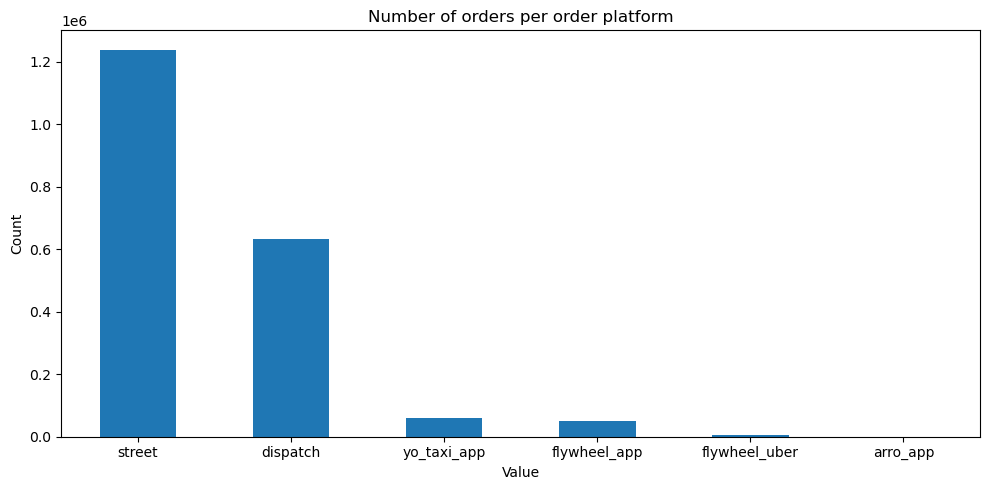

In [24]:
value_counts = raw_df['hail_type'].value_counts() #defining different taxi order methods. 

"code by ChatGPT"
#creating a barplot in order to present the number of taxi order per platform.
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar')

plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.title('Number of orders per order platform')
plt.tight_layout()
plt.show()


### Most of the costumer Taxi orders happends in the street more than other plattforms. 

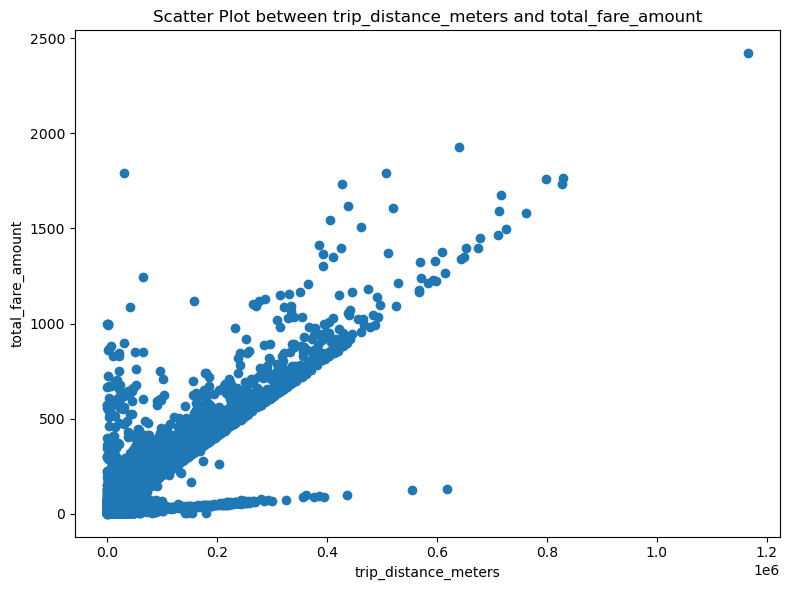

In [26]:
"code by ChatGPT"
#creating scatterplot in order to see the distrobution of the cost per meter. 
plt.figure(figsize=(8, 6))
plt.scatter(raw_df['trip_distance_meters'], raw_df['total_fare_amount'])

plt.xlabel('trip_distance_meters')
plt.ylabel('total_fare_amount')
plt.title('Scatter Plot between trip_distance_meters and total_fare_amount')

plt.tight_layout()
plt.show()

### We can see that we have a linear trend which indicates about Fixed payment per meter the Payment is mostly affected by the amount of travel on toll roads and additional fee payments. This is what causes the data to be spread out more widely.

In [28]:
value_counts_promo_rate = raw_df['promo_rate'].value_counts()
value_counts_promo_rate 

promo_rate
0.00     1990318
35.00         11
17.41          1
Name: count, dtype: int64

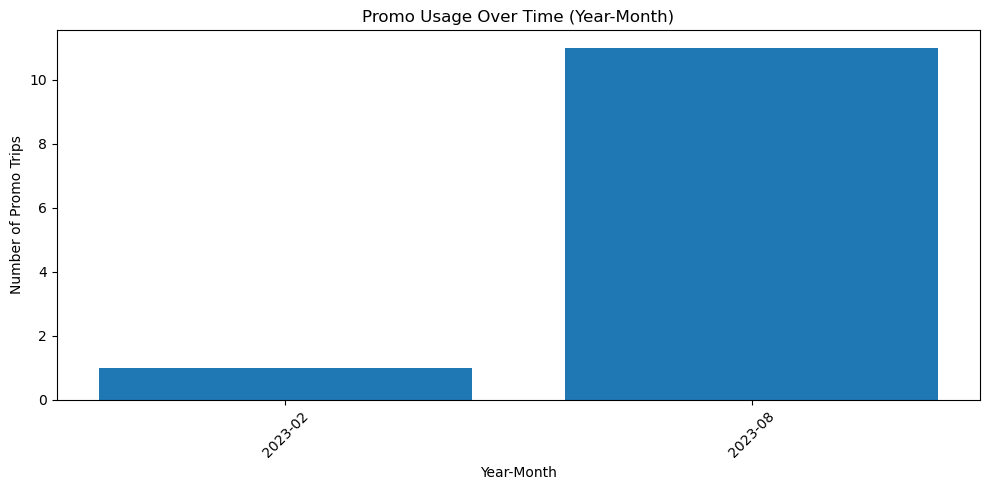

In [29]:
promo_df = raw_df[raw_df['promo_rate'].notna() & (raw_df['promo_rate'] != 0)]

"code by ChatGPT"
promo_by_month = (
    promo_df
    .groupby('year_month')
    .size()
    .reset_index(name='promo_count')
    .sort_values('year_month')
)
plt.figure(figsize=(10,5))
plt.bar(promo_by_month['year_month'], promo_by_month['promo_count'])
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Number of Promo Trips')
plt.title('Promo Usage Over Time (Year-Month)')
plt.tight_layout()
plt.show()

In [30]:
# We can see promo_rate price is taking place only on August that's mean it was a specific management decision and it doesnt indicate on costumer behavior or a seasonal fix price (holiday discount). 
#thats why we can remove this column. 
raw_df = raw_df.drop(columns = "promo_rate")

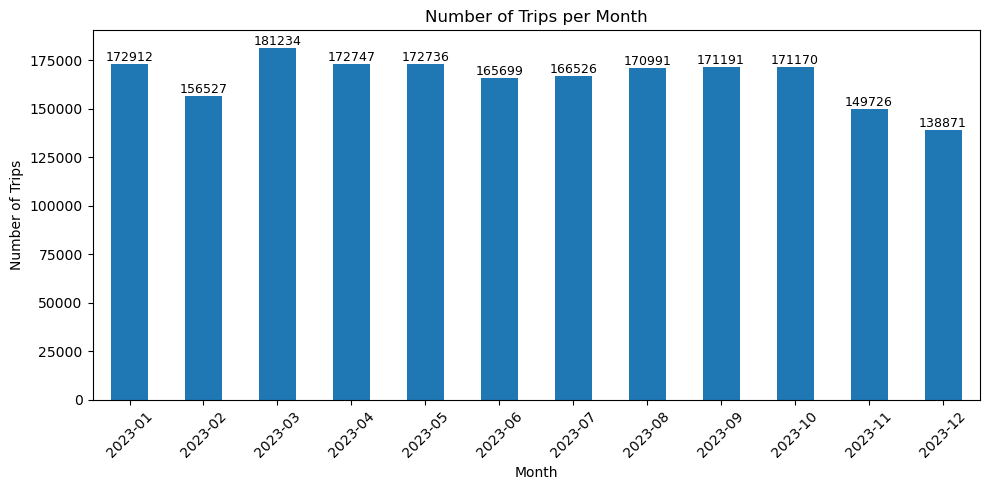

In [31]:
#Checking how many trips there are per month.
trip_per_month2 = (raw_df['year_month'].value_counts().sort_index())
trip_per_month2

fig, ax = plt.subplots(figsize=(10, 5))
bars = trip_per_month2.plot(kind='bar', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Trips')
ax.set_title('Number of Trips per Month')
ax.tick_params(axis='x', rotation=45)

"code by ChatGPT"
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f'{int(height)}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=9)

plt.tight_layout()
plt.show()


##### After investigating the data and according to the business segmentation, the fluctuations are affected by weather, holidays, tourism/business. 
##### March is the highest because the weather is the most comfortable during the year. 
##### November, December (holiday months) are the lowest because this is the time when local people travel for vacations outside the city and therefore there is less intra-city travel.

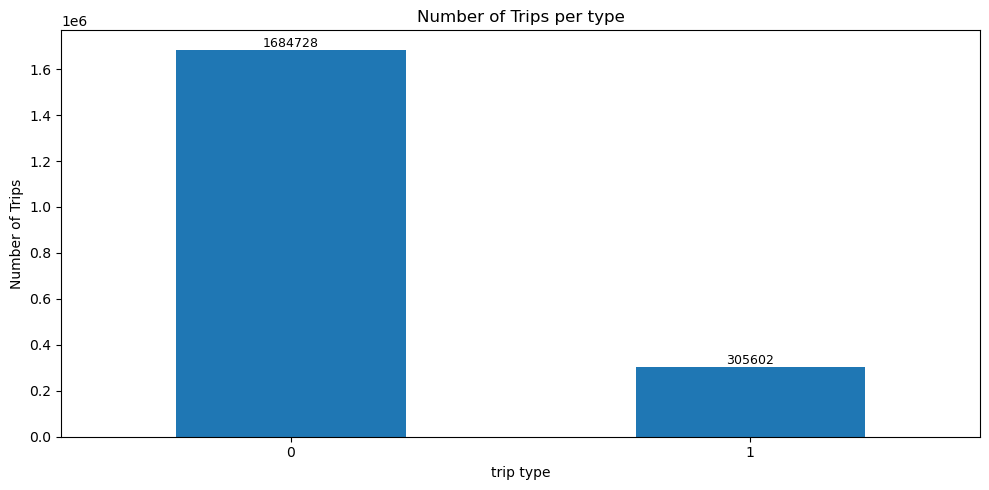

In [33]:
"code by ChatGPT"
day_night = (raw_df['is_night'].value_counts().sort_index())
day_night

"code by ChatGPT"
fig, ax = plt.subplots(figsize=(10, 5))
bars = day_night.plot(kind='bar', ax=ax)
ax.set_xlabel('trip type')
ax.set_ylabel('Number of Trips')
ax.set_title('Number of Trips per type')
ax.tick_params(axis='x', rotation=360)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f'{int(height)}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=9)

plt.tight_layout()
plt.show()

### Insight: There are more trips during the day than at night.

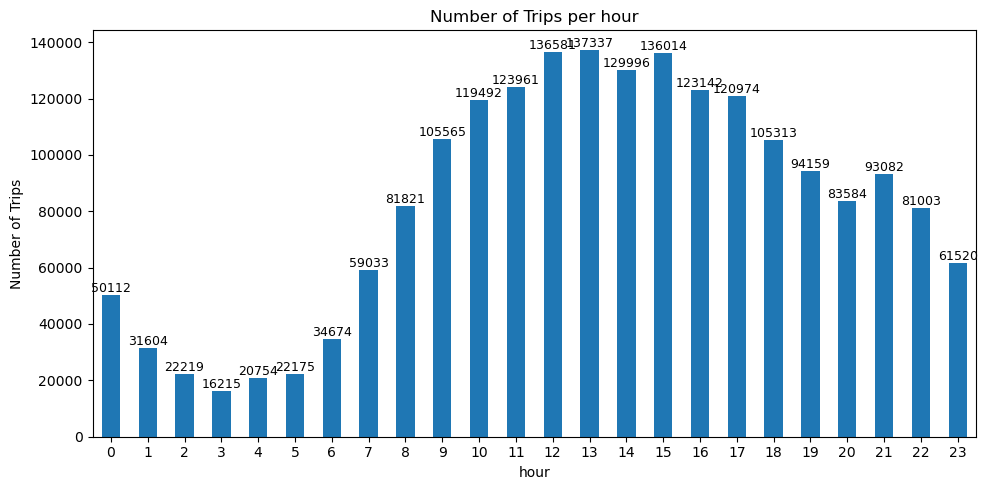

In [35]:
"code by ChatGPT"
hour_of_day = (raw_df['hour_of_day'].value_counts().sort_index())
hour_of_day

fig, ax = plt.subplots(figsize=(10, 5))
bars = hour_of_day.plot(kind='bar', ax=ax)
ax.set_xlabel('hour')
ax.set_ylabel('Number of Trips')
ax.set_title('Number of Trips per hour')
ax.tick_params(axis='x', rotation=360)

"code by ChatGPT"
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f'{int(height)}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=9)

plt.tight_layout()
plt.show()

### Insight: Most of the trips are between 12:00 pm t0 15:00 pm

## Step 4- Machine Learning

### * Unsupervised models:

##### We took samples from the data that will represent the population because our data is too big and it took long time to run it. 

### Finding types of trips by K Means:

##### We want to test an operational metric, meaning we only look at time and distance and not profits, so we chose columns that are not related to money.

In [42]:
numeric_features = ["trip_distance_meters","hour_sin","hour_cos","is_weekend","is_night","duration_minutes",
                    "pickup_location_latitude","pickup_location_longitude"]

"code by ChatGPT"
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric_features)],
        sparse_threshold=1.0)

In [43]:
"code by ChatGPT"
SAMPLE_N = min(100000, len(raw_df))
df_sample = raw_df.sample(n=SAMPLE_N, random_state=42)

"code by ChatGPT"
X_sample = preprocessor.fit_transform(df_sample)

"code by ChatGPT"
results = []
for k in range(2, 11):
    km = MiniBatchKMeans(n_clusters=k, batch_size=20000, n_init=5, random_state=42)
    labels = km.fit_predict(X_sample)

    sil = silhouette_score(X_sample, labels, sample_size=min(20000, SAMPLE_N), random_state=42)
    dbi = davies_bouldin_score(X_sample.toarray() if hasattr(X_sample, "toarray") else X_sample, labels)
    chi = calinski_harabasz_score(X_sample.toarray() if hasattr(X_sample, "toarray") else X_sample, labels)

    results.append({"k": k, "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": chi})

"code by ChatGPT"
scores_df = pd.DataFrame(results).sort_values("silhouette", ascending=False)
best_k = int(scores_df.iloc[0]["k"]) 
scores_df.head(10)


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.355775,1.227926,23610.737395
8,10,0.347072,1.202044,20423.856105
6,8,0.340302,1.218393,21045.782020
1,3,0.334813,1.398321,26353.612403
5,7,0.324292,1.222344,21898.810192
7,9,0.287478,1.268391,19870.851222
4,6,0.276575,1.511827,18966.418318
3,5,0.273692,1.516473,21267.990792
2,4,0.259002,1.350037,23555.371892


#### Silhouette Score  represent the clustering quality -  2 is the highest
#### Davies-Bouldin score represents how much the clusters are Dense and separated   2 is not the lowest but It is among the lowest.
#### Calinski-Harabasz = 2 it is among the highest - high is best
# 2 is the best K! 

In [45]:
"code by ChatGPT"
X_full = preprocessor.transform(raw_df)
final_kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=42,
    batch_size=50000,
    n_init=5)

raw_df['cluster_kmeans'] = final_kmeans.fit_predict(X_full)


In [46]:
raw_df["cluster_kmeans"]

1          0
2          1
5          1
7          0
8          0
          ..
3735561    0
3735562    0
3735563    1
3735564    0
3735565    1
Name: cluster_kmeans, Length: 1990330, dtype: int32

### Cluster Profiling

In [48]:
"code by ChatGPT"
cluster_profile = (
    raw_df
    .groupby('cluster_kmeans')
    .agg({
        'trip_distance_meters': 'mean',
        'tolls': 'mean',
        'is_night': 'mean',
        'is_weekend': 'mean',
        'sfo_pickup': 'mean',
        'duration_minutes' : 'mean',
        'speed_kmh' :'mean',
        'fare_per_km':'mean',
        'fare_per_minute':'mean',
        'minutes_per_km':'mean',
        'tip_ratio':'mean'
    })
)

cluster_profile


,trip_distance_meters,tolls,is_night,is_weekend,sfo_pickup,duration_minutes,speed_kmh,fare_per_km,fare_per_minute,minutes_per_km,tip_ratio
cluster_kmeans,,,,,,,,,,,
0,5162.875493,0.012958,0.134740,0.239889,0.023822,13.361063,20.954770,5.084575,1.435009,0.000004,0.018176
1,24279.011101,0.275225,0.194121,0.274689,0.911423,29.737042,54.313618,2.860653,2.457575,0.000002,0.009350


##### Cluster 0 - short Trip featured by almost not paying tolls fares, very slow driving of 20 KN/H and high ratio of fare per KM and almost not have pickups from the airport. 
##### Cluster 1 -  long Trip fearued by driving from the airport, more driving throw fare bridgs ,long time driving, average speed of 54 KM/H and lower fare per KM. 

##### Which type of the Trips is likely to be more profitable?
### Cluster 0 of course! 
#### the custumers pays more per km and the driver takes them to a close location. and the tips ratio are higher! 
 

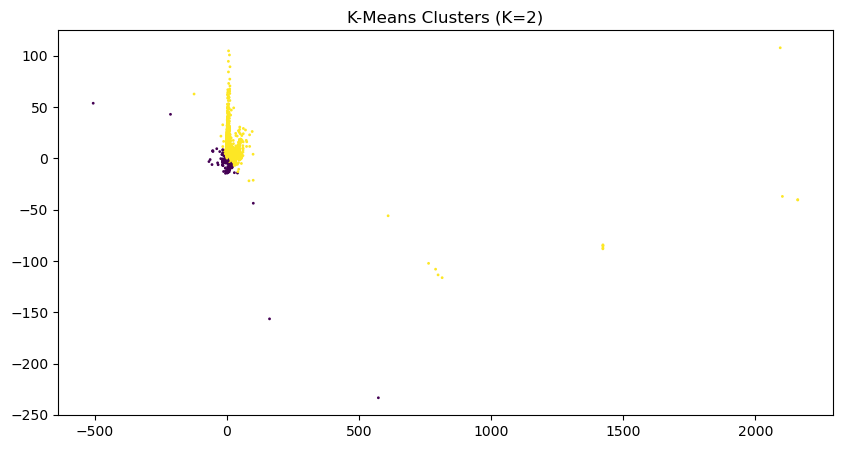

In [50]:
"code by ChatGPT"
X_2d = PCA(n_components=2).fit_transform(X_full)

plt.figure(figsize=(10,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=raw_df['cluster_kmeans'], s=1)
plt.title('K-Means Clusters (K=2)')
plt.show()


the plot visualizes the K-Means clustering results with k=2 after dimensionality reduction. Each point represents a taxi trip, and colors indicate different clusters. we can see there are 2 clusters very dence around the 0 point. and we have a lot of outliners. Kmeans very sensetive to outlines. althugh the shiluett score is good we can see that it has very small outlines effects slightly.

## Finding Hot Pickup locations by DBSCAN:

### Checking where most pickups happen

In [54]:
"code by ChatGPT"
N = min(100000, len(raw_df))
sample = raw_df[["pickup_location_latitude", "pickup_location_longitude"]].dropna().sample(N, random_state=42)

"code by ChatGPT"
#eps=0.03:Suitable for San Francisco building & min_samples=30:Statistical+Business Threshold.
db = DBSCAN(eps=0.003, min_samples=30, n_jobs=-1)
labels = db.fit_predict(sample.values)

sample_out = raw_df.loc[sample.index].copy()
sample_out["cluster_dbscan_pickup"] = labels 

In [55]:
"code by ChatGPT"
n_noise = list(sample_out["cluster_dbscan_pickup"]).count(-1)
print(f"Points classified as noise (-1): {n_noise}")

Points classified as noise (-1): 3821


In [56]:
# see the samples cluster splitting
sample_out['cluster_dbscan_pickup'].value_counts().sort_index()

cluster_dbscan_pickup
-1      3821
 0     63724
 1     30496
 2       173
 3        48
 4        78
 5        63
 6        61
 7       128
 8       129
 9       272
 10       52
 11       44
 12       52
 13       87
 14      109
 15       52
 16       59
 17       47
 18       35
 19       63
 20       43
 21       39
 22      135
 23       24
 24       33
 25       37
 26       33
 27       33
 28       30
Name: count, dtype: int64

In [57]:
"code by ChatGPT"
grid = 0.003  # Aproximate 300 meters 
geo_sample = sample_out.copy()
geo_sample["area_cell"] = (
    (geo_sample["pickup_location_latitude"] / grid).round().astype(str) + "_" +
    (geo_sample["pickup_location_longitude"] / grid).round().astype(str)
)

In [58]:
"code by ChatGPT"
cross = (
    geo_sample
    .groupby(["area_cell", "cluster_dbscan_pickup"])
    .size()
    .reset_index(name="trip_count")
    .sort_values(["area_cell", "cluster_dbscan_pickup"]))


#### We chose to make the map code "raw" because it overload the file and slow down the runnig of the notebook. 
#### You can run it at the end if you want. 
#### We added a picture of the map result to show you:

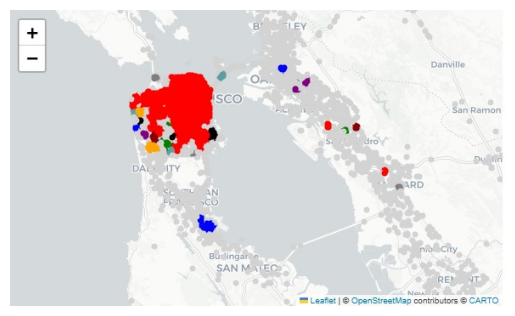

In [60]:
"code by ChatGPT"
url = "https://github.com/Greenlight5/Advanced-Topics-in-Machine-Learning/blob/main/DBSCAM%20Clustering%20map.png?raw=true"

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

response = requests.get(url, headers=headers)
response.raise_for_status()

img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')
plt.show()


## Clustering map code: 

### Conclusion: 
##### Every color represent a cluster. We can see that the red zone is a huge center of gatherings close to each other, it is the area with the highest and most consistent demand. It is a very dense urban structure that includes many areas of interest that merge into one large area.
##### The small colored clusters represent:
##### A small, defined geographic area with a lower number of trips than the center but still enough to define it as a cluster.
##### That is, there are not always trips, but many trips in the same place, at certain times.
##### Therefore, it is not defined as "noise" but as a potential area of ​​interest.
##### These clusters can influence the business strategy by segmenting each cluster by travel hours, days, and dates in order to understand whether there is any trend there.

### Further Discussion:
##### What makes a trip to be an efficient?
##### Efficient trip is when the ratio of distance per duration time  is less than 1. thats mean the drive took a short  time and there was not traffic. (represented by avg_speed column) 
##### What is a profitable trip? 
##### Profitable trip is when the fare amount is high or the tip per km ratio is higher than 1. (represented by fare_per_min column)

### * Supervised Models: 

##### Building a target column - profitable/unprofitable in preparation for classification models

In [66]:
"code by ChatGPT"
df1= raw_df.copy()
q_low = df1["fare_per_minute"].quantile(0.25)
q_high = df1["fare_per_minute"].quantile(0.75)

"code by ChatGPT"
df1["target_profitable"] = np.where(
    df1["fare_per_minute"] >= q_high, 1,
    np.where(df1["fare_per_minute"] <= q_low, 0, np.nan)
)

df1 = df1.dropna(subset=["target_profitable"])

In [67]:
"code by ChatGPT"
# reffering the type clustering as featur for the model to learn different types of trips.
df1["cluster_kmeans"] = df1["cluster_kmeans"].astype("category")

#### Making a  Binary column of: do the trip is in the red area(cluster = 0 ):

In [69]:
"code by ChatGPT"
CORE_CLUSTER_ID = 0
core_points = sample_out[sample_out['cluster_dbscan_pickup'] == CORE_CLUSTER_ID][['pickup_location_latitude', 'pickup_location_longitude']]

In [70]:
"code by ChatGPT"
lat_min, lat_max = core_points['pickup_location_latitude'].min(), core_points['pickup_location_latitude'].max()
lon_min, lon_max = core_points['pickup_location_longitude'].min(), core_points['pickup_location_longitude'].max()

In [71]:
"code by ChatGPT"
df1['is_core_area'] = (
    (df1['pickup_location_latitude'] >= lat_min) &
    (df1['pickup_location_latitude'] <= lat_max) &
    (df1['pickup_location_longitude'] >= lon_min) &
    (df1['pickup_location_longitude'] <= lon_max)
).astype(int)


In [72]:
"code by ChatGPT"
# normalization function  
def minmax(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-9)

df1['fare_per_km_norm'] = minmax(df1['fare_per_km'])
df1['distance_km_norm'] = minmax(df1['trip_distance_meters']/1000)

##### According to our clustering we did in dbscan and k-means we decided that a profitable trip is the more the trip distance is short  and the more fare per meter is high and if the trip is in the most attraction area(the red cluster). 

In [74]:
"code by ChatGPT"
# making a reasonable formula to  defined id the trip is profitable by weights. 
df1['profitability_score'] = (
    0.5 * df1['fare_per_km_norm'] +    # money per meter
    0.3 * df1['is_core_area'] +           # red area
    0.2 * (1 - df1['distance_km_norm'])      #short trip
)

In [75]:
"code by ChatGPT"
threshold = df1['profitability_score'].quantile(0.7) 

df1['is_profitable'] = (df1['profitability_score'] >= threshold).astype(int) # creating a profitable column. 

#### We chose to represent the profitability index using a percentile because we do not have all the information that includes all travel expenses such as fuel, maintenance, etc. Therefore, we cannot unequivocally decide whether the trip was profitable, but only in relation to other trips.

#### Sanity check:

In [78]:
"code by ChatGPT"
df1.groupby('is_profitable').agg({
    'trip_distance_meters': 'mean',
    'total_fare_amount': 'mean',
    'fare_per_km': 'mean',
    'is_core_area': 'mean'
})

,trip_distance_meters,total_fare_amount,fare_per_km,is_core_area
is_profitable,,,,
0,17620.893764,47.941857,3.186131,0.374835
1,2343.319302,13.428347,6.512836,0.999997


#### The profitability classification based on percentiles shows a clear behavioral and spatial separation. Profitable trips are significantly shorter, generate almost twice the revenue per meter, and almost exclusively come from the central demand area, while unprofitable trips are significantly longer and less efficient despite higher absolute fares.

### Logistic Regression

In [81]:
features = ['trip_distance_meters','is_night','is_weekend','hour_sin','hour_cos','cluster_kmeans','is_core_area']

X = df1[features]
y = df1['is_profitable']

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

"code by ChatGPT"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [82]:
"code by ChatGPT"
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


In [83]:
"code by ChatGPT"
model = LogisticRegression(max_iter=2000)
model.fit(X_train_sc, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


Accuracy: 0.9614548620995697
AUC: 0.993700870837046
F1-score: 0.936
Confusion matrix:
 [[202328   6680]
 [  4829  84748]]


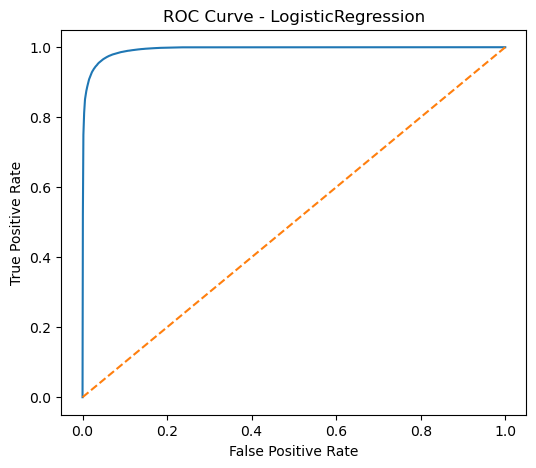

In [84]:
"code by ChatGPT"
y_logis_pred = model.predict(X_test_sc)
y_logis_proba = model.predict_proba(X_test_sc)[:,1]

"code by ChatGPT"
logis_accuracy = accuracy_score(y_test, y_logis_pred)
logis_AUC = roc_auc_score(y_test, y_logis_proba)
logis_cm = confusion_matrix(y_test, y_logis_pred)
logis_f1 = f1_score(y_test, y_logis_pred)

"code by ChatGPT"
print("Accuracy:", logis_accuracy)
print("AUC:",logis_AUC )
print(f"F1-score: {logis_f1:.3f}")
print("Confusion matrix:\n",logis_cm )

"code by ChatGPT"
logis_fpr, logis_tpr, _ = roc_curve(y_test, y_logis_proba)
plt.figure(figsize=(6,5))
plt.plot(logis_fpr, logis_tpr)
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LogisticRegression")
plt.show()


In [85]:
"code by ChatGPT"
coef_df = pd.DataFrame({
    "feature": features,
    "coef": model.coef_[0],
    "odds_ratio": np.exp(model.coef_[0])
}).sort_values("odds_ratio", ascending=False)

coef_df


,feature,coef,odds_ratio
6,is_core_area,17.254582,3.115802e+07
5,cluster_kmeans,7.321288,1.512151e+03
2,is_weekend,0.015895,1.016022e+00
1,is_night,-0.016887,9.832552e-01
4,hour_cos,-0.154925,8.564790e-01
3,hour_sin,-0.197805,8.205300e-01
0,trip_distance_meters,-44.642241,4.093749e-20


### conclusion:

##### We can see that "trip_distance_meters" has a strong negative effect. The longer the trip, the chance of profit decreases significantly.

##### Variables that increase profit: 
##### "hour_of_day" - Later hours are more profitable.
##### "day_of_week" - Later days of the week are more profitable.

##### Variables with weak/negative impact:
##### "is_night" – less profitable on average.
##### "is_weekend" – slight negative impact.

### Random Forest

In [91]:
"code by ChatGPT"
rf_model = RandomForestClassifier(
    n_estimators=200,  #Stable enough
    max_depth=10, #Prevents overfitting
    min_samples_leaf=50, #Because it's big data.
    random_state=42,
    n_jobs=-1  #Uses all cores
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [92]:
"code by ChatGPT"
y_rf_pred = rf_model.predict(X_test)
y_rf_proba = rf_model.predict_proba(X_test)[:, 1]

"code by ChatGPT"
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_AUC = roc_auc_score(y_test, y_rf_proba)
rf_cm = confusion_matrix(y_test, y_rf_pred)
rf_f1 = f1_score(y_test, y_rf_pred)

print("Accuracy:",rf_accuracy )
print("AUC:",rf_AUC )
print(f"F1-score: {rf_f1:.3f}")
print("Confusion Matrix:\n", rf_cm)

Accuracy: 0.9636418440310129
AUC: 0.9938313369520766
F1-score: 0.939
Confusion Matrix:
 [[204229   4779]
 [  6077  83500]]


In [93]:
"code by ChatGPT"
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feat_imp


,feature,importance
0,trip_distance_meters,0.752113
6,is_core_area,0.134734
5,cluster_kmeans,0.092690
4,hour_cos,0.009319
3,hour_sin,0.007688
1,is_night,0.003221
2,is_weekend,0.000236


#### Trip length controls almost entirely,all other variables contribute very little.                                                                   This is a very strong finding, because Random Forest can exploit interactions that are complex. Yet it chose distance as the central factor.         And this actually strengthens the validity of the findings, because different, independent models reached the same central conclusion.

### XGBOOST

In [96]:
"code by ChatGPT"
X_xgb_train = X_train.copy()
X_xgb_test = X_test.copy()

"code by ChatGPT"
X_xgb_train["cluster_kmeans"] = X_xgb_train["cluster_kmeans"].astype(int)
X_xgb_test["cluster_kmeans"] = X_xgb_test["cluster_kmeans"].astype(int)

"code by ChatGPT"
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss")


xgb_model.fit(X_xgb_train, y_train)

"code by ChatGPT"
y_xgb_pred = xgb_model.predict(X_xgb_test)
y_xgb_proba = xgb_model.predict_proba(X_xgb_test)[:, 1]

"code by ChatGPT"
xgb_accuracy = accuracy_score(y_test, y_xgb_pred)
xgb_AUC =roc_auc_score(y_test, y_xgb_proba)
xgb_cm = confusion_matrix(y_test, y_xgb_pred)
xgb_f1 = f1_score(y_test, y_xgb_pred)

print("Accuracy:",xgb_accuracy )
print("AUC:",xgb_AUC )

"code by ChatGPT"
print(f"F1-score: {xgb_f1:.3f}")
print("Confusion Matrix:\n", xgb_cm)

Accuracy: 0.9636987792420919
AUC: 0.99420176432681
F1-score: 0.939
Confusion Matrix:
 [[204027   4981]
 [  5858  83719]]


In [97]:
"code by ChatGPT"
xgb_imp = pd.DataFrame({
    "feature": X_train.columns,  
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

xgb_imp


,feature,importance
6,is_core_area,0.498058
0,trip_distance_meters,0.311062
5,cluster_kmeans,0.177826
3,hour_sin,0.005950
4,hour_cos,0.003789
1,is_night,0.002310
2,is_weekend,0.001005


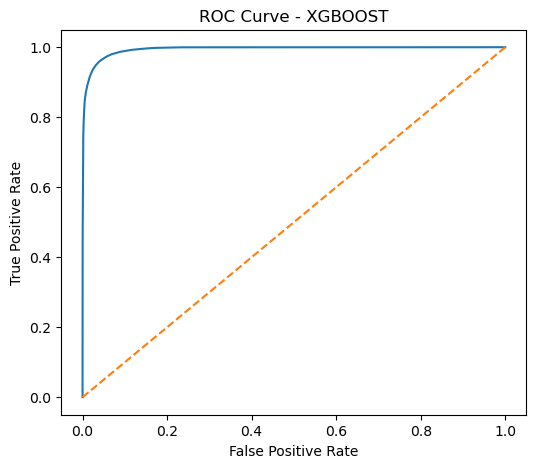

In [98]:
"code by ChatGPT"
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_xgb_proba)
plt.figure(figsize=(6,5))
plt.plot(xgb_fpr, xgb_tpr)
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBOOST")
plt.show()


The curve “sticks” to the upper left corner,Very far from the diagonal line (random guess).
Interpretation:
The model almost always ranks profitable trips over unprofitable ones

ROC tests how well the model knows how to distinguish between profitable and unprofitable without depending on a single decision threshold, and the high AUC shows that the separation is very clear in the data.

### LightGBM

In [102]:
"code by ChatGPT"
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True
)
 
lgb_model.fit(X_train, y_train)

"code by ChatGPT"
y_lgb_pred = lgb_model.predict(X_test)
y_lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

"code by ChatGPT"
lgb_accuracy = accuracy_score(y_test, y_lgb_pred)
lgb_AUC = roc_auc_score(y_test, y_lgb_proba)
lgb_cm = confusion_matrix(y_test, y_lgb_pred)
lgb_f1 = f1_score(y_test, y_lgb_pred)


print("Accuracy:",lgb_accuracy)
print("AUC:",lgb_AUC)

"code by ChatGPT"
print(f"F1-score: {lgb_f1:.3f}")
print("Confusion Matrix:\n", lgb_cm)


[LightGBM] [Info] Number of positive: 209011, number of negative: 487686
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 696697, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300003 -> initscore=-0.847285
[LightGBM] [Info] Start training from score -0.847285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.9636317966408225
AUC: 0.9942102563880599
F1-score: 0.939
Confusion Matrix:
 [[204060   4948]
 [  5911  83666]]


In [103]:
"code by ChatGPT"
lgb_imp = pd.DataFrame({
    "feature": X_train.columns,  
    "importance": lgb_model.feature_importances_
}).sort_values("importance", ascending=False)

lgb_imp


,feature,importance
0,trip_distance_meters,5426
3,hour_sin,3280
4,hour_cos,2888
2,is_weekend,1513
5,cluster_kmeans,903
6,is_core_area,563
1,is_night,413


The importance is the number of times the feature was used to split the model trees ( how many times LightGBM “chosen” it to make a decision).
Distance and time are what really “drive” the model.

### Neural Network 

In [106]:
"code by ChatGPT"
nn_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=20,
    random_state=42)

nn_model.fit(X_train_sc, y_train)

"code by ChatGPT"
y_nn_pred = nn_model.predict(X_test_sc)
y_nn_proba = nn_model.predict_proba(X_test_sc)[:, 1]

"code by ChatGPT"
nn_accuracy = accuracy_score(y_test, y_nn_pred)
nn_AUC =  roc_auc_score(y_test, y_nn_proba)
nn_cm = confusion_matrix(y_test, y_nn_pred)
nn_f1 = f1_score(y_test, y_nn_pred)

print("Accuracy:",nn_accuracy)
print("AUC:",nn_AUC)
print(f"F1-score: {nn_f1:.3f}")
print("Confusion Matrix:\n", nn_cm)

C:\Users\Israel\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9632265519031432
AUC: 0.9939664908434447
F1-score: 0.939
Confusion Matrix:
 [[203765   5243]
 [  5737  83840]]


## Model comparison table

In [108]:
"code by ChatGPT"
# Buildng a comparision table
results = [
    {"Model": "Logistic Regression",  "F1": logis_f1, "Accuracy": logis_accuracy, "AUC":logis_AUC},
    {"Model": "Random Forest",        "F1": rf_f1, "Accuracy":rf_accuracy, "AUC":rf_AUC},
    {"Model": "XGBoost",              "F1": xgb_f1, "Accuracy": xgb_accuracy, "AUC":xgb_AUC},
    {"Model": "LightGBM",             "F1": lgb_f1, "Accuracy": lgb_accuracy, "AUC":lgb_AUC},
    {"Model": "Neural Network",       "F1": nn_f1, "Accuracy": nn_accuracy, "AUC":nn_AUC},
]

#creating df
df_results = pd.DataFrame(results)

#sort by the F1 score
df_results = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)

df_results


,Model,F1,Accuracy,AUC
0,XGBoost,0.939201,0.963699,0.994202
1,LightGBM,0.939060,0.963632,0.994210
2,Random Forest,0.938962,0.963642,0.993831
3,Neural Network,0.938542,0.963227,0.993966
4,Logistic Regression,0.936416,0.961455,0.993701


## Step 4-Integration & Business Insights

##### After analyzing the data and dividing the trips into attractive areas and examining the types of trips, we came to the conclusion that there are 2 types of trips: short trips and long trips.
##### A short trip is usually more profitable because the customer pays more money on average for a relatively short trip compared to long trips. In addition, the percentage of the tip he leaves on a short trip is higher than on a long trip.

##### After further analysis of the data, we found that there is an area where there is more customer gathering. This is an area called an attractive area.

##### A driver who receives a trip order wants to know whether the trip is profitable for him using several indicators:
##### 1. What is the time of the trip - indicates congestion on the road
##### 2. The distance of the trip - short/long
##### 3. Will he receive another order when he drops off the passenger and continue his trip chain. -

### Conclusion 1: A profitable trip will be a short trip, close and where the attractive area is located.

##### We measured the profitability index. This index is unstable, meaning there is no clear-cut right or wrong, so the best index to know which model is the best is to look at the F1 index. It describes the stability of the model.
### Conclusion 2: The Best model is XGBOOST